In [ ]:
# Resources used
# https://www.youtube.com/watch?v=uQj5UNhCPuo
# https://www.youtube.com/watch?v=nhT56blfRpE
# https://github.com/kiecodes/genetic-algorithms

In [22]:
from random import choices, choice, randint, randrange, random
from math import log10
import matplotlib.pyplot as plt 
import os
import time
%matplotlib inline

In [2]:
def parse_input(filename):
    with open(filename, "r") as f:
        data = f.read()
    data = [i for i in data.split("\n") if i.strip() != ""]
    
    data = data[1:]
    client_data = [[data[i], data[i+1]] for i in range(0, len(data), 2)]
    
    for i in range(len(client_data)):
        likes, dislikes = client_data[i]
        likes = set(likes.split(" ")[1:])
        dislikes = set(dislikes.split(" ")[1:] or [])
        client_data[i] = [likes, dislikes]
    return client_data

In [3]:
def score_pizza(pizza_ingredients: set[str]):
    pizza_ingredients = set(pizza_ingredients)
    score = 0
    global client_data
    for client_info in client_data:
        client_likes, client_dislikes = client_info
        client_likes_pizza = True
        
        # all the ingredients they like are on the pizza
        for liked_ingredient in client_likes:
            if liked_ingredient not in pizza_ingredients:
                client_likes_pizza = False
                break

        # none of the ingredients they dislike are on the pizza 
        if client_likes_pizza:
            for disliked_ingredient in client_dislikes:
                if disliked_ingredient in pizza_ingredients:
                    client_likes_pizza = False
                    break
        if client_likes_pizza:
            score += 1
    return score

In [4]:
def getAllIngredients():
    global client_data
    allIngredients = set()
    for client_info in client_data:
        client_likes, client_dislikes = client_info
        allIngredients = allIngredients.union(client_likes)
        allIngredients = allIngredients.union(client_dislikes)
    return sorted(list(allIngredients))

In [5]:
def getAllDislikedIngredients():
    global client_data
    result = set() 
    for client_info in client_data:
        client_likes, client_dislikes = client_info
        result = result.union(client_dislikes)
    return result

In [126]:
def getIngredientsThatWereNeverDisliked():
    global client_data
    allIngredients = set(getAllIngredients())
    allDislikes = getAllDislikedIngredients()
    
    result = set()
    for i in allIngredients:
        if i not in allDislikes:
            result.add(i)
    
    return result

def getAllIngredientsThatWereDislikedAtleastOnce():
    global client_data
    allIngredients = set(getAllIngredients())
    neverDislikedIngredients = getIngredientsThatWereNeverDisliked()
    return sorted(list(allIngredients.difference(neverDislikedIngredients)))

In [127]:
def generate_genome():
    'Generates random genome'
    global genomeLength
    return choices([0, 1], k=genomeLength)

def generate_population(size):
    'Generates list of random genomes of provided size'
    return [generate_genome() for _ in range(size)]

def genome_to_ingredients(genome):
    'Convert genome to what pizza ingredients they represent'
    global allIngredients
    ingredients = set()
    for idx, bit in enumerate(genome):
        if bit == 1:
            ingredients.add(allIngredients[idx])
    return ingredients

def get_genome_score(genome, fixed=set()):
    'Get score of genome i.e. how many clients were fine with the pizza'
    ingredients = genome_to_ingredients(genome)
#     return score_pizza(ingredients)
    return score_pizza(ingredients.union(fixed))

In [128]:
def selection_pair(population):
    return choices(
        population=population,
        weights=[get_genome_score(g) for g in population],
        k = 2
    )

def single_point_crossover(genome_a, genome_b):
    p = randint(1, len(genome_a)-1)
    return genome_a[0:p] + genome_b[p:], genome_b[0:p] + genome_a[p:]

def mutation(g, count = 1, probability = 0.5):
    'Flip `count` bits of genome `g` with a chance of `probability`'
    for _ in range(count):
        idx = randrange(len(g))
        if random() < probability:
            g[idx] = g[idx] ^ 1         # Bit-Flip
    return g

In [129]:
def run_evolution(population_size=10, initial_genome_suggestions = None):
    global genomeLength, bestGenome, bestScore, points, alreadyChosen

    if initial_genome_suggestions is not None:
        population = generate_population(population_size-len(initial_genome_suggestions)) + initial_genome_suggestions
    else:
        population = generate_population(population_size)

    population = sorted(population, key=lambda g: -get_genome_score(g, alreadyChosen))
    prevScore = 0
    
    i = 0
    while True:
        next_gen = population[:2] # Top 2 candidates
        
        for _ in range(int(len(population) / 2) - 1):
            parents = selection_pair(population)
            # Reproduce
            child_a, child_b = single_point_crossover(parents[0], parents[1])
            # Mutation
            child_a, child_b = mutation(child_a), mutation(child_b)
            # Add them to next gen
            next_gen += [child_a, child_b]
        
        population = next_gen
        population = sorted(population, key=lambda g: -get_genome_score(g, alreadyChosen))
        i += 1
        bestGenome = population[0]

        if i % 50 == 0:
            bestScore = get_genome_score(bestGenome, alreadyChosen)
            print(f"Gen: {i} | Current Best Score: {bestScore}" + " "*15, end="\r")
            points.append((i, bestScore))

NOTE:<br>
We are gonna include the ingredients that were disliked in the pizza by default <br>
The evolution will only executed for the ingredients that were disliked at least once <br>
<br>
Final Pizza Recipe = Ingredients that were never disliked + Ingredients found by running the evolution


In [ ]:
files = ['./input/' + file for file in os.listdir('./input')]
input_file = files[3]
client_data = parse_input(input_file)
# Ignoring the ingredient that were never disliked
allIngredients = list(getAllIngredientsThatWereDislikedAtleastOnce())
bestGenome = None
bestScore = 0
genomeLength = len(allIngredients)
points = [] # List of (generationNumber, BestScoreAtThatGeneration)
# Ingredients that were never disliked
alreadyChosen = getIngredientsThatWereNeverDisliked()

print(f"File selected: {input_file}")
print(f"No. of ingredients: {len(allIngredients)}")
print(f"No. of clients: {len(client_data)}")
print(f"No. of permutations possible: 2^{len(allIngredients)} or 10^{round(log10(2)*len(allIngredients), 2)}")
print(f"Max Score Limit: {len(client_data)}")
print(time.strftime("Time started: %H:%M"))

run_evolution(population_size=15)

File selected: ./input/d_difficult.in.txt
No. of ingredients: 500
No. of clients: 9368
No. of permutations possible: 2^500 or 10^150.51
Max Score Limit: 9368
Time started: 00:53


In [131]:
# Final Pizza Recipe = Ingredients that were never disliked + Ingredients found by running the evolution
best_recipe = genome_to_ingredients(bestGenome).union(alreadyChosen)
score_pizza(best_recipe)
# print(f"{len(best_recipe)} {' '.join(best_recipe)}")

1781

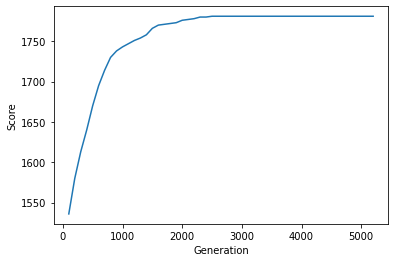

In [132]:
x, y = [x for x, _ in points], [y for _, y in points]
plt.plot(x, y)
plt.xlabel('Generation')
plt.ylabel('Score')
plt.show()

In [ ]:
# Testcase D
# Gen: 2800 | Current Best Score: 1782
# Gen: 4000 | Current Best Score: 1783

# Testcase E
# Gen: 1500 | Current Best Score: 593
# Gen: 2000 | Current Best Score: 652
# Gen: 3000 | Current Best Score: 745
# Gen: 3700 | Current Best Score: 804
# Gen: 4000 | Current Best Score: 824
# Gen: 5050 | Current Best Score: 900
# Gen: 5050 | Current Best Score: 900
# Gen: 6000 | Current Best Score: 934
# Gen: 7650 | Current Best Score: 1001
# Gen: 10000 | Current Best Score: 1001
# Gen: 11000 | Current Best Score: 1083

In [ ]:
# One of the best genomes found
# [1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0]